<a href="https://colab.research.google.com/github/yanamushka/ML_portfolio/blob/main/LSTM_%D0%B4%D0%BB%D1%8F_%D0%BF%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7%D1%83%D0%B2%D0%B0%D0%BD%D0%BD%D1%8F_%D1%87%D0%B0%D1%81%D0%BE%D0%B2%D0%B8%D1%85_%D1%80%D1%8F%D0%B4%D1%96%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Introduction

###The Dataset
We'll be working with the "International airline passengers" dataset. This dataset spans from January 1949 to December 1960, containing 144 observations. It features a single numerical characteristic: "Passengers," representing the monthly passenger count in thousands.
###Project Goal
The primary goal of this project is to develop a robust model capable of accurately forecasting the number of international airline passengers (measured in thousands) based on historical data. This is a regression problem, where we'll use past monthly passenger figures to predict the value for the upcoming month.



1. [Introduction](#introduction)
2. [Data Preprocessing](#data-preprocessing)
3. [Model Training](#model-training)
4. [Model Evaluation](#model-evaluation)

#Data Preprocessing

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from matplotlib import pyplot as plt

url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url)
df.set_index('Month', inplace=True)
display(df.head())

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


In [ ]:
passangers = df['Passengers'].to_numpy(dtype=np.float32)
passangers

array([112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
       118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
       114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
       162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
       209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
       272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
       302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
       315., 364., 347., 312., 274., 237., 278., 284., 277., 317., 313.,
       318., 374., 413., 405., 355., 306., 271., 306., 315., 301., 356.,
       348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318.,
       362., 348., 363., 435., 491., 505., 404., 359., 310., 337., 360.,
       342., 406., 396., 420., 472., 548., 559., 463., 407., 362., 405.,
       417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.,
       432.], dtype=float32)

Splitting the dataset for train and validation using older data for training and newer data for validation

In [ ]:
train_size = int(len(passangers) * 0.67)
test_size = len(passangers) - train_size
train, test = passangers[0:train_size], passangers[train_size:]

Converting dataset into the proper format for neural network with create_dataset function

In [ ]:
def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset)):
      end = i + lookback
      if end >= len(dataset):
        break
      X.append(dataset[i:end])
      y.append(dataset[end])
    return torch.tensor(X), torch.tensor(y).unsqueeze(1)

We will predict the number of passangers for the next day based on the previous one, so the lookback will be set to 1.

In [ ]:
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([95, 1]) torch.Size([95, 1])
torch.Size([47, 1]) torch.Size([47, 1])


<ipython-input-5-ad411bb43241>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  return torch.tensor(X), torch.tensor(y).unsqueeze(1)


In [ ]:
# Developing an LSTM-based neural network (AirModel) for passenger count prediction.
class AirModel(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers=1):
    super(AirModel, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size

    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
    self.linear = nn.Linear(hidden_size, 1)

  def forward(self, x):
    out, _ = self.lstm(x)
    out = self.linear(out)
    return out

In [ ]:
model = AirModel(input_size=1, hidden_size=50)
model(torch.tensor([[112.]]))

tensor([[-0.0450]], grad_fn=<AddmmBackward0>)

In [ ]:
#reates a TensorDataset for training data and a DataLoader to handle batching and shuffling.
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
DataLoader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)

#Model Training

In [ ]:
def train_model(model):
  epochs = 2000
  valid_every = 100
  current_loss = 0
  all_losses = []
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  for epoch in range(epochs):
    model.train()
    losses = []
    for X_batch, y_batch in DataLoader:
      preds = model(X_batch)
      loss = criterion(preds, y_batch)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      losses.append(loss.item())
    avg_loss = np.mean(losses)
    all_losses.append(avg_loss)

    if (epoch+1)%100 == 0:
      model.eval()
      with torch.no_grad():
        train_preds = model(X_train)
        test_preds = model(X_test)
        train_rmse = np.sqrt(criterion(train_preds, y_train).item())
        test_rmse = np.sqrt(criterion(test_preds, y_test).item())
        print(f'Epoch {epoch+1}: train RMSE {train_rmse:.5f}, test RMSE {test_rmse:.5f}')

In [ ]:
train_model(model)

Epoch 100: train RMSE 179.11208, test RMSE 373.37186
Epoch 200: train RMSE 141.68871, test RMSE 332.68768
Epoch 300: train RMSE 110.72800, test RMSE 296.35046
Epoch 400: train RMSE 87.94029, test RMSE 264.81322
Epoch 500: train RMSE 69.55675, test RMSE 237.85651
Epoch 600: train RMSE 51.53979, test RMSE 205.19230
Epoch 700: train RMSE 40.06836, test RMSE 178.86418
Epoch 800: train RMSE 33.19512, test RMSE 158.31211
Epoch 900: train RMSE 28.85084, test RMSE 140.92844
Epoch 1000: train RMSE 26.10852, test RMSE 126.64542
Epoch 1100: train RMSE 25.25957, test RMSE 120.18223
Epoch 1200: train RMSE 24.61452, test RMSE 111.81075
Epoch 1300: train RMSE 23.53051, test RMSE 102.84836
Epoch 1400: train RMSE 23.77595, test RMSE 98.59326
Epoch 1500: train RMSE 23.17479, test RMSE 92.92505
Epoch 1600: train RMSE 22.99623, test RMSE 90.31700
Epoch 1700: train RMSE 23.95345, test RMSE 94.23330
Epoch 1800: train RMSE 22.25991, test RMSE 87.84429
Epoch 1900: train RMSE 23.34069, test RMSE 86.34998
Epoch

#Model Evaluation

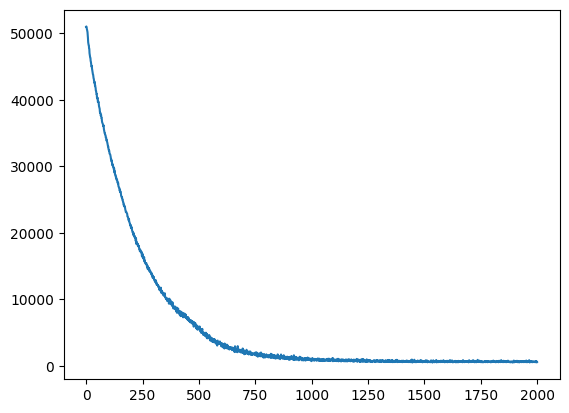

In [ ]:
import matplotlib.pyplot as plt

plt.plot(all_losses)
plt.show()

From the chart Loss moving to 0 starting from 1000 iteration, but veru slow. So the model learned, but we will have to estimate quality of the predictions

<ipython-input-16-71199556b989>:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_plot[lookback:train_size] = model(X_train)[:, -1]
<ipython-input-16-71199556b989>:13: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1]


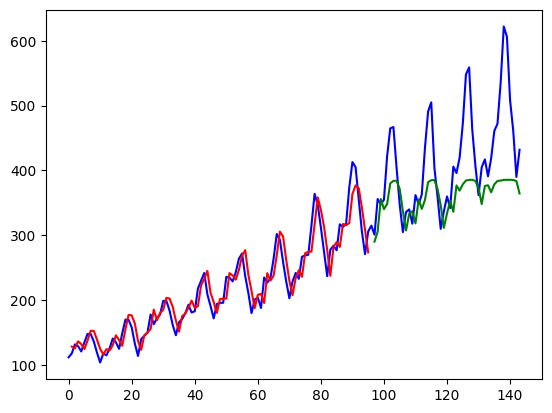

In [ ]:
timeseries = passangers

def plot_predicts():
  with torch.no_grad():
      train_plot = np.ones_like(timeseries) * np.nan
      y_pred = model(X_train)
      y_pred = y_pred[:, -1]
      train_plot[lookback:train_size] = model(X_train)[:, -1]

      test_plot = np.ones_like(timeseries) * np.nan
      test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1]

  plt.plot(timeseries, c='b')
  plt.plot(train_plot, c='r')
  plt.plot(test_plot, c='g')
  plt.show()

plot_predicts()

This chart provides a clear visual representation of how our Long Short-Term Memory (LSTM) model performs in forecasting time series data. Specifically, it displays the actual historical values of the time series alongside the model's predictions for both the training and test datasets.
The blue line on the chart represents the actual, observed values.The red line illustrates the training predictions generated by our LSTM model. Finally, the green line depicts the test predictions.

Based on the chart model doesn't predict well on the test data. Let's try to change hidden state and compare the results

In [ ]:
model2 = AirModel(input_size=1, hidden_size=100)
train_model(model2)

Epoch 100: train RMSE 129.14428, test RMSE 318.42540
Epoch 200: train RMSE 81.24179, test RMSE 253.18571
Epoch 300: train RMSE 52.22063, test RMSE 207.16189
Epoch 400: train RMSE 36.43758, test RMSE 167.73623
Epoch 500: train RMSE 29.30933, test RMSE 139.88359
Epoch 600: train RMSE 25.18119, test RMSE 120.21780
Epoch 700: train RMSE 24.20901, test RMSE 105.89511
Epoch 800: train RMSE 23.32488, test RMSE 94.95421
Epoch 900: train RMSE 22.92944, test RMSE 87.03148
Epoch 1000: train RMSE 22.09048, test RMSE 83.20689
Epoch 1100: train RMSE 22.49566, test RMSE 81.28605
Epoch 1200: train RMSE 22.58423, test RMSE 78.45848
Epoch 1300: train RMSE 24.19838, test RMSE 80.80251
Epoch 1400: train RMSE 21.88845, test RMSE 70.89220
Epoch 1500: train RMSE 22.54555, test RMSE 71.26769
Epoch 1600: train RMSE 22.47842, test RMSE 74.39388
Epoch 1700: train RMSE 22.00438, test RMSE 76.52573
Epoch 1800: train RMSE 22.76504, test RMSE 82.78037
Epoch 1900: train RMSE 22.48298, test RMSE 74.19457
Epoch 2000: t

With the new hidden_state model result has been improved. Test RMSE decreased from 82.38 to 76.47